In [ ]:
pip install google-api-python-client
pip install isodate

In [9]:
import json
from googleapiclient.discovery import build
import isodate
from googleapiclient.errors import HttpError

# Carica la chiave API
DEVELOPER_KEY = json.load(open('key.json'))['key']

# Costruzione del client API di YouTube
youtube = build('youtube', 'v3', developerKey=DEVELOPER_KEY)

# Esegui una ricerca per il canale "ReWake"
request = youtube.search().list(
    part="snippet",
    maxResults=5,
    q="ReWake",
    type="channel"
)
response = request.execute()

# Estrai l'ID del canale di ReWake
channel_id = response['items'][0]['id']['channelId']
print(f"Channel ID: {channel_id}")

# Funzione per ottenere l'ID della playlist di caricamenti
def get_upload_playlist_id(channel_id):
    request = youtube.channels().list(
        part="contentDetails",
        id=channel_id
    )
    response = request.execute()
    return response['items'][0]['contentDetails']['relatedPlaylists']['uploads']

# Funzione per ottenere i video dalla playlist di caricamenti
def get_videos_from_playlist(playlist_id):
    videos = []
    next_page_token = ''
    while next_page_token is not None:
        request = youtube.playlistItems().list(
            part="snippet,contentDetails",
            playlistId=playlist_id,
            maxResults=50,
            pageToken=next_page_token
        )
        response = request.execute()
        for item in response['items']:
            video_id = item['snippet']['resourceId']['videoId']
            # Filtra i video con durata maggiore di 60 secondi
            if is_normal_video(video_id):
                videos.append(video_id)
        next_page_token = response.get('nextPageToken')
    return videos

# Funzione per verificare se un video è un video normale (non uno short)
def is_normal_video(video_id):
    request = youtube.videos().list(
        part="contentDetails",
        id=video_id
    )
    response = request.execute()
    duration = response['items'][0]['contentDetails']['duration']
    # Converti la durata da ISO 8601 a secondi
    duration_seconds = parse_duration(duration)
    # Considera video con durata maggiore di 60 secondi come video normali
    return duration_seconds > 60

# Funzione per convertire la durata ISO 8601 in secondi
def parse_duration(duration):
    return isodate.parse_duration(duration).total_seconds()

# Funzione per ottenere i dettagli di un commento
def get_commenter_details(commentThread):
    comment = commentThread['snippet']['topLevelComment']['snippet']
    commenter = comment['authorDisplayName']
    likes = comment['likeCount']
    text = comment['textOriginal']
    published_at = comment['publishedAt']  # Aggiungi la data di pubblicazione
    return commenter, likes, text, published_at

# Funzione per ottenere i commentatori unici di un video con il numero di like, il testo del commento e la data di pubblicazione
def get_unique_commenters_and_details(video_id):
    unique_commenters = {}  # Usa un dizionario per garantire l'unicità dei commentatori
    next_page_token = ''
    while next_page_token is not None:
        try:
            request = youtube.commentThreads().list(
                part="snippet",
                videoId=video_id,
                maxResults=100,
                pageToken=next_page_token
            )
            response = request.execute()
            for item in response['items']:
                commenter, likes, text, published_at = get_commenter_details(item)
                if commenter in unique_commenters:
                    unique_commenters[commenter]['likes'] += likes  # Somma i like se il commentatore ha commentato più volte
                    unique_commenters[commenter]['comments'].append({'text': text, 'published_at': published_at})  # Aggiungi il nuovo commento con la data
                else:
                    unique_commenters[commenter] = {'likes': likes, 'comments': [{'text': text, 'published_at': published_at}]}  # Aggiungi il commentatore con i suoi like e commento
            next_page_token = response.get('nextPageToken')
        except HttpError as e:
            if e.resp.status == 403:
                print(f"Comments are disabled for video {video_id}")
                break
            else:
                raise
        next_page_token = response.get('nextPageToken', None)
    return unique_commenters

# Raccolta dei dati
playlist_id = get_upload_playlist_id(channel_id)
videos = get_videos_from_playlist(playlist_id)

# Stampa il numero totale di video analizzati
print(f"Numero totale di video analizzati: {len(videos)}")

# Memorizzazione dei commentatori unici con i like, i commenti e le date di pubblicazione per ciascun video
commentators_per_video = {}
total_unique_commenters = set()

for video_id in videos:
    unique_commenters_and_details = get_unique_commenters_and_details(video_id)
    commentators_per_video[video_id] = unique_commenters_and_details  # Memorizza come dizionario
    total_unique_commenters.update(unique_commenters_and_details.keys())  # Aggiungi i commentatori al set globale

# Stampa il numero totale di commentatori unici su tutti i video
print(f"Numero totale di commentatori unici: {len(total_unique_commenters)}")

# Salva i dati nel file JSON
try:
    with open('LikesCommentiData.json', 'w') as outfile:
        json.dump(commentators_per_video, outfile, indent=4)
    print("File JSON salvato correttamente.")
except Exception as e:
    print(f"Errore durante il salvataggio del file JSON: {e}")


Channel ID: UCgcNSRIeeq7j2Kx6DxZoeZA
Numero totale di video analizzati: 230
Comments are disabled for video UeQL-udRrPs
Comments are disabled for video J0pau8mRspk
Numero totale di commentatori unici: 13140
File JSON salvato correttamente.


In [ ]:
pip install networkx

In [12]:
import json
from itertools import combinations
import networkx as nx
from collections import defaultdict
from datetime import datetime

# Carica il file JSON con i commentatori unici e i like per ogni video
with open('LikesCommentiData.json', 'r') as file:
    data = json.load(file)

# Creazione di un grafo
G = nx.Graph()

# Dizionari per memorizzare informazioni su coppie di commentatori e attributi dei commentatori
commenter_pairs = defaultdict(lambda: {'count': 0, 'videos': set()})
commenter_attributes = defaultdict(lambda: {'likes': 0, 'comments': [], 'earliest_date': None})

# Itera attraverso ciascun video e i suoi commentatori
for video_id, commenters in data.items():
    for commenter, attributes in commenters.items():
        commenter_attributes[commenter]['likes'] += attributes['likes']  # Somma i like
        commenter_attributes[commenter]['comments'].append(attributes['comments'])  # Aggiungi i commenti

        # Gestione delle date: conserva la data più vecchia
        comment_date = attributes.get('published_at')
        if comment_date:
            comment_date = datetime.strptime(comment_date, "%Y-%m-%dT%H:%M:%SZ")
            if commenter_attributes[commenter]['earliest_date'] is None or comment_date < commenter_attributes[commenter]['earliest_date']:
                commenter_attributes[commenter]['earliest_date'] = comment_date

    # Estrai i commentatori unici per questo video
    commenters_set = set(commenters.keys())

    # Conta il numero di video in comune per ciascuna coppia di commentatori e traccia i video comuni
    for commenter1, commenter2 in combinations(commenters_set, 2):
        commenter_pairs[(commenter1, commenter2)]['count'] += 1
        commenter_pairs[(commenter1, commenter2)]['videos'].add(video_id)  # Aggiungi il video corrente ai video comuni

# Aggiungi al grafo solo le coppie di commentatori con almeno 2 video in comune
for (commenter1, commenter2), data in commenter_pairs.items():
    if data['count'] >= 2:
        # Serializza l'elenco dei video in una stringa JSON o separata da virgole
        common_videos_serialized = json.dumps(list(data['videos']))  # Usa json.dumps per serializzare la lista
        G.add_edge(commenter1, commenter2, weight=data['count'], common_videos=common_videos_serialized)

# Rimuovi i nodi isolati (senza archi)
isolated_nodes = list(nx.isolates(G))
G.remove_nodes_from(isolated_nodes)

# Aggiungi attributi ai nodi (likes, commenti serializzati, e data più vecchia)
for commenter, attributes in commenter_attributes.items():
    if commenter in G:  # Aggiungi attributi solo ai nodi che esistono nel grafo
        comments_serialized = json.dumps(attributes['comments'])  # Serializza la lista di commenti in una stringa JSON
        earliest_date_str = attributes['earliest_date'].strftime("%Y-%m-%d") if attributes['earliest_date'] else "N/A"
        G.add_node(commenter, likes=attributes['likes'], comments=comments_serialized, earliest_date=earliest_date_str)

# Numero di nodi e archi nella rete
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

print(f"Numero totale di nodi (commentatori unici): {num_nodes}")
print(f"Numero totale di archi (relazioni basate sui video in comune): {num_edges}")

# Salva la rete in un formato che può essere caricato in strumenti come Gephi
nx.write_gexf(G, 'rete_con_data.gexf')


Numero totale di nodi (commentatori unici): 3183
Numero totale di archi (relazioni basate sui video in comune): 36951


In [13]:
#CALCOLO DELLA DENSITA'

import networkx as nx

# Carica la rete dal file GEXF
G = nx.read_gexf('rete_con_data.gexf')

# Calcola la densità della rete
density = nx.density(G)

# Stampa la densità
print(f"La densità della rete è: {density}")


La densità della rete è: 0.00729658049430971


In [14]:
#Grado ReWake
import networkx as nx

# Carica la rete dal file .gexf
G = nx.read_gexf('rete_con_data.gexf')

# Nome del nodo di cui vuoi calcolare il grado
nodo = "@ReWake"

# Controlla se il nodo esiste nella rete
if nodo in G:
    grado = G.degree(nodo)
    print(f"Il grado del nodo '{nodo}' è: {grado}")
else:
    print(f"Il nodo '{nodo}' non esiste nella rete.")


Il grado del nodo '@ReWake' è: 1228


In [15]:
#Media Grado 

import networkx as nx

# Carica la rete dal file .gexf
G = nx.read_gexf('rete_con_data.gexf')

# Calcola il grado medio della rete
average_degree = sum(dict(G.degree()).values()) / G.number_of_nodes()

print(f"Il grado medio della rete è: {average_degree:.2f}")


Il grado medio della rete è: 23.22


In [ ]:
pip install numpy

In [18]:
#Mediana Grado 

import networkx as nx
import numpy as np

# Carica la rete dal file .gexf
G = nx.read_gexf('rete_con_data.gexf')

# Calcola il grado di ciascun nodo
degree_sequence = [degree for node, degree in G.degree()]

# Calcola la mediana del grado
median_degree = np.median(degree_sequence)

print(f"Mediana del grado: {median_degree}")


Mediana del grado: 9.0


In [19]:
#Mediana Grado 

import networkx as nx
import numpy as np

# Carica la rete dal file .gexf
G = nx.read_gexf('rete_con_data.gexf')

# Calcola il grado di ciascun nodo
degree_sequence = [degree for node, degree in G.degree()]

# Calcola la mediana del grado
median_degree = np.median(degree_sequence)

print(f"Mediana del grado: {median_degree}")


Mediana del grado: 9.0


In [20]:
#Mediana Grado 

import networkx as nx
import numpy as np

# Carica la rete dal file .gexf
G = nx.read_gexf('rete_con_data.gexf')

# Calcola il grado di ciascun nodo
degree_sequence = [degree for node, degree in G.degree()]

# Calcola la mediana del grado
median_degree = np.median(degree_sequence)

print(f"Mediana del grado: {median_degree}")


Mediana del grado: 9.0


In [ ]:
pip install matplotlib

Grado medio: 23.741368078175896


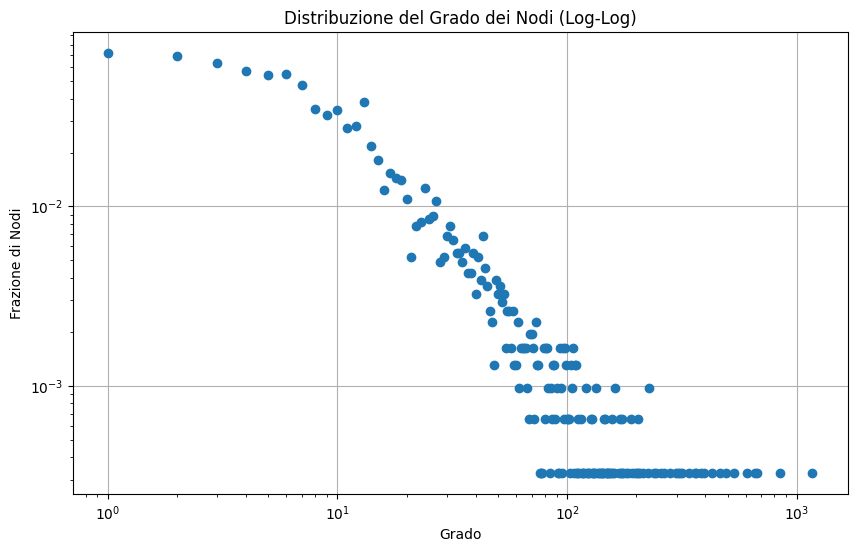

In [26]:
#CALCOLO GRADO MEDIO E DISTRIBUZIONE GRADO (rete scale-free)


import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Carica la rete dal file .gexf
G = nx.read_gexf('rete_con_data.gexf')

# Calcola il grado di ciascun nodo
degree_sequence = [degree for node, degree in G.degree()]

# Calcola la distribuzione del grado
degree_counts = np.bincount(degree_sequence)
degrees = np.nonzero(degree_counts)[0]
distribution = degree_counts[degrees] / sum(degree_counts)

# Calcola il grado medio
average_degree = np.mean(degree_sequence)
print(f"Grado medio: {average_degree}")

plt.figure(figsize=(10, 6))
plt.loglog(degrees, distribution, marker='o', linestyle='none')
plt.title('Distribuzione del Grado dei Nodi (Log-Log)')
plt.xlabel('Grado')
plt.ylabel('Frazione di Nodi')
plt.grid(True)
plt.show()



In [9]:
import networkx as nx

# Carica il file della rete in formato GEXF
G = nx.read_gexf('rete_con_data.gexf')

# Trova le componenti connesse della rete
connected_components = list(nx.connected_components(G))

# Seleziona la componente gigante (quella con il maggior numero di nodi)
giant_component = max(connected_components, key=len)

# Crea un subgrafo della componente gigante
G_giant = G.subgraph(giant_component)

# Calcola la lunghezza media dei percorsi minimi per la componente gigante
average_shortest_path_length = nx.average_shortest_path_length(G_giant)
print(f"Lunghezza media dei percorsi minimi nella componente gigante: {average_shortest_path_length}")


# Calcola il coefficiente di clustering medio
average_clustering_coefficient = nx.average_clustering(G)
print(f"Coefficiente di Clustering Medio: {average_clustering_coefficient}")



Lunghezza media dei percorsi minimi nella componente gigante: 2.6659003400308063
Coefficiente di Clustering Medio: 0.6716215188164312


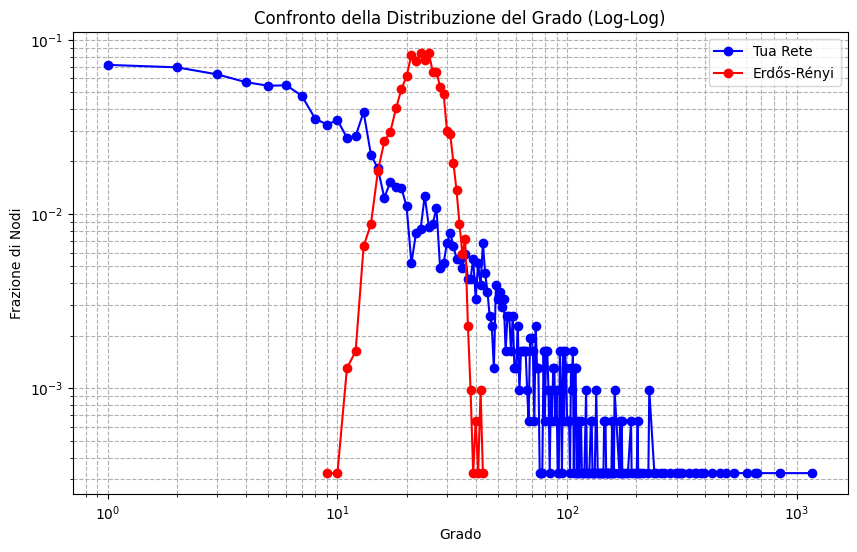

In [36]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Carica la rete dal file .gexf
G = nx.read_gexf('rete_con_data.gexf')

# Numero di nodi e archi nella tua rete
n = G.number_of_nodes()
m = G.number_of_edges()

# Probabilità di collegamento per il modello Erdős-Rényi
p = 2 * m / (n * (n - 1))

# Genera una rete Erdős-Rényi con lo stesso numero di nodi e probabilità di collegamento
G_er = nx.erdos_renyi_graph(n, p)

# Calcola la distribuzione del grado per la tua rete
degree_sequence = [degree for node, degree in G.degree()]
degree_counts = np.bincount(degree_sequence)
degrees = np.nonzero(degree_counts)[0]
distribution = degree_counts[degrees] / sum(degree_counts)

# Calcola la distribuzione del grado per la rete Erdős-Rényi
degree_sequence_er = [degree for node, degree in G_er.degree()]
degree_counts_er = np.bincount(degree_sequence_er)
degrees_er = np.nonzero(degree_counts_er)[0]
distribution_er = degree_counts_er[degrees_er] / sum(degree_counts_er)

# Visualizza il confronto tra le distribuzioni del grado in scala log-log
plt.figure(figsize=(10, 6))
plt.loglog(degrees, distribution, 'bo-', label='Tua Rete')
plt.loglog(degrees_er, distribution_er, 'ro-', label='Erdős-Rényi')
plt.title('Confronto della Distribuzione del Grado (Log-Log)')
plt.xlabel('Grado')
plt.ylabel('Frazione di Nodi')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()


In [12]:
import networkx as nx

# Definisci i parametri della rete ER
n = 3076  # Numero di nodi
p = 0.0077  # Probabilità di creazione di un arco (uguale alla densità)

# Crea una rete randomica ER usando il modello Erdos-Renyi
ER_random_graph = nx.erdos_renyi_graph(n, p)

# Calcola il coefficiente di clustering medio della rete ER
average_clustering_coefficient_ER = nx.average_clustering(ER_random_graph)
print(f"Coefficiente di Clustering Medio della Rete ER: {average_clustering_coefficient_ER}")

# Verifica se la rete è connessa
if nx.is_connected(ER_random_graph):
    # Calcola la lunghezza media dei cammini minimi
    average_shortest_path_length_ER = nx.average_shortest_path_length(ER_random_graph)
    print(f"Lunghezza Media dei Cammini Minimi della Rete ER: {average_shortest_path_length_ER}")
else:
    # Estrai la componente gigante
    largest_component = max(nx.connected_components(ER_random_graph), key=len)
    ER_giant_component = ER_random_graph.subgraph(largest_component)

    # Calcola la lunghezza media dei cammini minimi della componente gigante
    average_shortest_path_length_ER = nx.average_shortest_path_length(ER_giant_component)
    print(f"Lunghezza Media dei Cammini Minimi della Componente Gigante della Rete ER: {average_shortest_path_length_ER}")


Coefficiente di Clustering Medio della Rete ER: 0.007972973325649352
Lunghezza Media dei Cammini Minimi della Rete ER: 2.840421199530591


Numero totale di componenti connesse: 6
Numero di nodi nella Giant Component: 3060
Diametro della Giant Component: 5


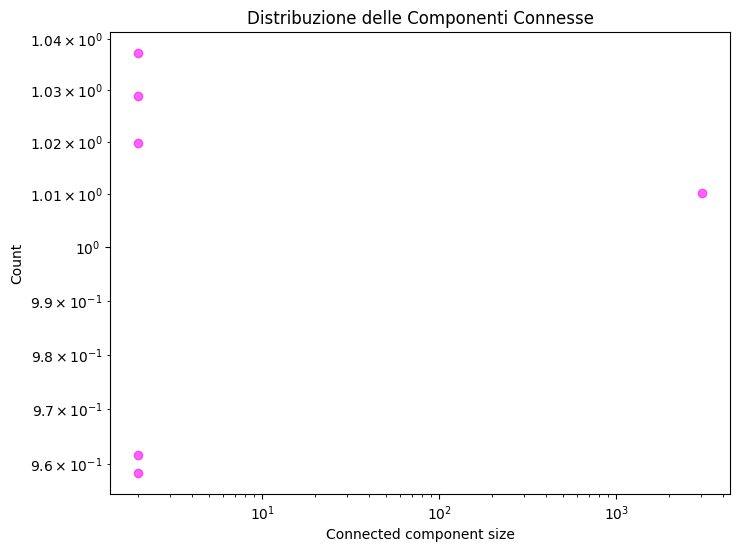

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Carica la rete dal file .gexf
G = nx.read_gexf('rete_con_data.gexf')

# Trova le componenti connesse (per grafi non orientati)
connected_components = list(nx.connected_components(G))
num_connected_components = len(connected_components)
print(f"Numero totale di componenti connesse: {num_connected_components}")

# Trova la componente gigante (quella con il maggior numero di nodi)
giant_component = max(connected_components, key=len)
num_nodes_giant_component = len(giant_component)
print(f"Numero di nodi nella Giant Component: {num_nodes_giant_component}")

# Crea un subgrafo della componente gigante
G_giant = G.subgraph(giant_component)

# Calcola il diametro della componente gigante
diameter = nx.diameter(G_giant)
print(f"Diametro della Giant Component: {diameter}")

# Calcola le dimensioni delle componenti connesse
component_sizes = [len(component) for component in connected_components]

# Aggiungi un po' di jitter all'asse Y per separare i punti
y_values = np.ones(len(component_sizes)) + np.random.normal(0, 0.05, len(component_sizes))

# Rappresentazione della distribuzione delle componenti connesse
plt.figure(figsize=(8, 6))
plt.scatter(component_sizes, y_values, color='magenta', alpha=0.6)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Connected component size")
plt.ylabel("Count")
plt.title("Distribuzione delle Componenti Connesse")
plt.show()



In [ ]:
pip install community

Degree Centrality (Top 10):
[('@ReWake', 0.37999350438454044), ('@cristianbruno4129', 0.2731406300746996), ('@TheKALV1N', 0.2234491718090289), ('@sonoquellochecambiaidea3480', 0.1997401753816174), ('@giovanni9039', 0.19584280610587854), ('@r1q17gold2', 0.18122767132185774), ('@sickuilgoat7099', 0.16466385189996752), ('@jacopomorini8915', 0.14842481325105553), ('@ellykellyreale', 0.12731406300746995), ('@kaseithebest1', 0.1269892822344917)]

Betweenness Centrality (Top 10):
[('@ReWake', 0.23793230572813268), ('@cristianbruno4129', 0.10588385642823342), ('@TheKALV1N', 0.07790612504981212), ('@sonoquellochecambiaidea3480', 0.06974105936469072), ('@giovanni9039', 0.05054655330358867), ('@r1q17gold2', 0.039339518347073756), ('@sickuilgoat7099', 0.03625970548082278), ('@jacopomorini8915', 0.036204272694633666), ('@ellykellyreale', 0.030545194982968), ('@kaseithebest1', 0.028723639193773125)]

Closeness Centrality (Top 10):
[('@ReWake', 0.6085750534723722), ('@cristianbruno4129', 0.5676415400

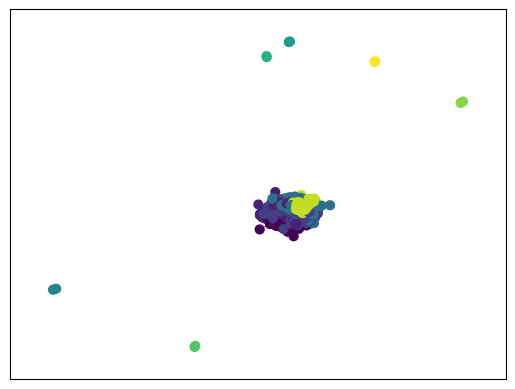

In [3]:
#CALCOLO DELLE CENTRALITA' E COMUNITA'

import networkx as nx
import community as community_louvain
import matplotlib.pyplot as plt

# Carica la rete dal file .gexf
G = nx.read_gexf('rete_con_data.gexf')

# Calcola la Degree Centrality
degree_centrality = nx.degree_centrality(G)

# Calcola la Betweenness Centrality
betweenness_centrality = nx.betweenness_centrality(G)

# Calcola la Closeness Centrality
closeness_centrality = nx.closeness_centrality(G)

# Calcola la Eigenvector Centrality
eigenvector_centrality = nx.eigenvector_centrality(G)

# Stampa dei risultati delle metriche
print("Degree Centrality (Top 10):")
print(sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10])

print("\nBetweenness Centrality (Top 10):")
print(sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10])

print("\nCloseness Centrality (Top 10):")
print(sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:10])

print("\nEigenvector Centrality (Top 10):")
print(sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:10])

print(f"\nModularità della rete: {modularity}")

Le 10 comunità più grandi per numero di nodi:
Comunità 4: 946 nodi
Comunità 2: 807 nodi
Comunità 1: 730 nodi
Comunità 0: 525 nodi
Comunità 12: 43 nodi
Comunità 8: 4 nodi
Comunità 13: 3 nodi
Comunità 6: 3 nodi
Comunità 9: 3 nodi
Comunità 7: 2 nodi
Comunità 4: Sovrapposizione del 0.74% tra tutti i nodi dal 2018 al 2024
Nodi comuni nella sovrapposizione nella Comunità 4:
 - @TheKALV1N
 - @ciaomario7030
 - @stefano5706
 - @slaghia666
 - @omarouadi9601
 - @marcolenda6627
Comunità 2: Sovrapposizione del 3.03% tra tutti i nodi dal 2018 al 2024
Nodi comuni nella sovrapposizione nella Comunità 2:
 - @erbreddaa
 - @thomaseldiablososa
 - @giovanni9039
Comunità 1: Sovrapposizione del 3.86% tra tutti i nodi dal 2018 al 2024
Nodi comuni nella sovrapposizione nella Comunità 1:
 - @gustavair9060
 - @Thirtyvisions
 - @s.m.s.mvsictm8852
 - @noia999FFF
 - @valeriooooo8676
 - @ellykellyreale
 - @ilcanaledimorry
 - @gabrieleleon9223
Comunità 0: Sovrapposizione del 5.52% tra tutti i nodi dal 2018 al 2024
No

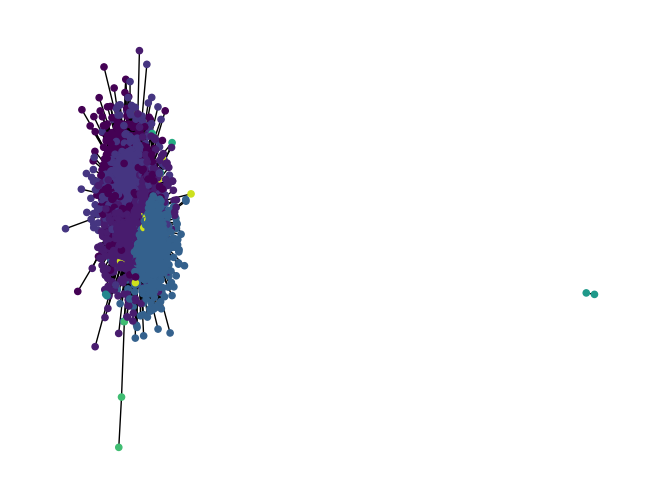

In [19]:
import networkx as nx
from collections import defaultdict
import json

# Carica la rete dal file .gexf
G = nx.read_gexf('rete_con_data.gexf')

# Rilevamento delle comunità usando l'algoritmo di Louvain
from community import community_louvain
partition = community_louvain.best_partition(G)

# Ordina le comunità per dimensione
community_sizes = defaultdict(int)
for community_id in partition.values():
    community_sizes[community_id] += 1
sorted_communities = sorted(community_sizes.items(), key=lambda x: x[1], reverse=True)

# Identifica le 10 comunità più grandi
top_communities = [community_id for community_id, _ in sorted_communities[:10]]

print("Le 10 comunità più grandi per numero di nodi:")
for community_id, size in sorted_communities[:10]:
    print(f"Comunità {community_id}: {size} nodi")

# Inizializza dizionari per i nodi delle comunità del 2018 e 2024
nodes_2018 = defaultdict(set)
nodes_2024 = defaultdict(set)

# Itera attraverso i nodi della rete per popolare i dizionari
for node, community_id in partition.items():
    if community_id in top_communities:
        if 'comments' in G.nodes[node]:  # Controlla che il nodo abbia l'attributo 'comments'
            comments = json.loads(G.nodes[node]['comments'])
            
            if isinstance(comments, list):
                for comment_list in comments:
                    if isinstance(comment_list, list):
                        for comment in comment_list:
                            if isinstance(comment, dict) and 'published_at' in comment:
                                comment_date = comment['published_at']
                                
                                # Verifica l'anno del commento e aggiungi il nodo al set appropriato
                                if '2018' in comment_date:
                                    nodes_2018[community_id].add(node)
                                elif '2024' in comment_date:
                                    nodes_2024[community_id].add(node)
                    else:
                        print(f"Struttura inattesa per comment_list: {comment_list}")
            else:
                print(f"Struttura inattesa per comments: {comments}")
        else:
            print(f"Nodo {node} non ha commenti associati.")

# Calcola la sovrapposizione in percentuale per le 10 comunità più grandi
for community_id in top_communities:
    nodes_in_2018 = nodes_2018[community_id]
    nodes_in_2024 = nodes_2024[community_id]
    overlap = len(nodes_in_2018 & nodes_in_2024)
    total = len(nodes_in_2018 | nodes_in_2024)
    percentage_overlap = (overlap / total) * 100 if total > 0 else 0
    print(f"Comunità {community_id}: Sovrapposizione del {percentage_overlap:.2f}% tra tutti i nodi dal 2018 al 2024")

    # Stampa i nodi che costituiscono la sovrapposizione
    if overlap > 0:
        print(f"Nodi comuni nella sovrapposizione nella Comunità {community_id}:")
        for node in nodes_in_2018 & nodes_in_2024:
            print(f" - {node}")

# Visualizzazione della Rete Focalizzata sulle 10 Comunità
subgraph_nodes = [node for node, community_id in partition.items() if community_id in top_communities]
subgraph = G.subgraph(subgraph_nodes)

pos = nx.spring_layout(subgraph)
nx.draw(subgraph, pos, with_labels=False, node_size=20, node_color=[partition[n] for n in subgraph_nodes])
plt.show()


/home/lazyfillo/PyVenv/socialmining/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/lazyfillo/PyVenv/socialmining/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


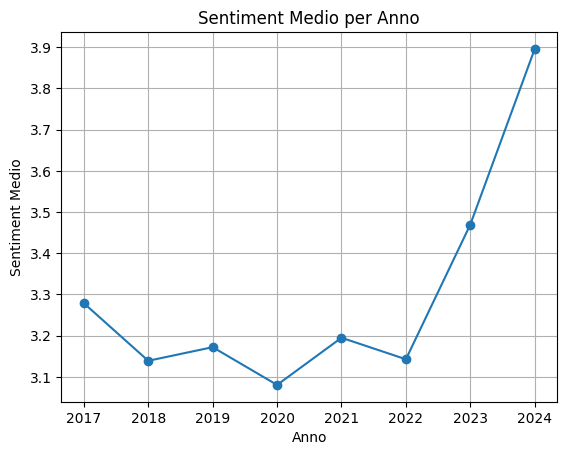

Anno: 2024, Sentiment Medio: 3.90
Anno: 2023, Sentiment Medio: 3.47
Anno: 2022, Sentiment Medio: 3.14
Anno: 2020, Sentiment Medio: 3.08
Anno: 2019, Sentiment Medio: 3.17
Anno: 2018, Sentiment Medio: 3.14
Anno: 2017, Sentiment Medio: 3.28
Anno: 2021, Sentiment Medio: 3.20


In [18]:
import json
from collections import defaultdict
from datetime import datetime
import matplotlib.pyplot as plt
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.nn.functional import softmax
import networkx as nx

# Carica il modello pre-addestrato e il tokenizer
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)

# Funzione per analizzare il sentimento
def analyze_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    probs = softmax(outputs.logits, dim=1)
    sentiment_score = torch.argmax(probs).item() + 1  # Ritorna il valore della classe (da 1 a 5)
    return sentiment_score

# Funzione per estrarre i commenti dai nodi della rete e raggrupparli per anno
def group_comments_by_year_from_graph(graph):
    comments_by_year = defaultdict(list)
    for node, data in graph.nodes(data=True):
        comments_serialized = data.get('comments', '[]')
        try:
            comments_data = json.loads(comments_serialized)
            for comment_list in comments_data:
                if isinstance(comment_list, list):
                    for comment in comment_list:
                        if isinstance(comment, dict) and 'text' in comment and 'published_at' in comment:
                            comment_text = comment['text']
                            published_at = comment['published_at']
                            year = datetime.strptime(published_at, "%Y-%m-%dT%H:%M:%SZ").year
                            comments_by_year[year].append(comment_text)
                        else:
                            print(f"Struttura inattesa per commento: {comment}")
                else:
                    print(f"Struttura inattesa per comment_list: {comment_list}")
        except json.JSONDecodeError as e:
            print(f"Errore nel parsing dei commenti per il nodo {node}: {e}")
    return comments_by_year

# Funzione per calcolare il sentiment medio per anno
def calculate_average_sentiment_by_year(comments_by_year):
    sentiments_by_year = {}
    for year, comments in comments_by_year.items():
        sentiments = [analyze_sentiment(comment) for comment in comments]
        average_sentiment = sum(sentiments) / len(sentiments) if sentiments else 0
        sentiments_by_year[year] = average_sentiment
    return sentiments_by_year

# Carica la rete dal file .gexf
G = nx.read_gexf('rete_con_data.gexf')

# Raggruppa i commenti per anno
comments_by_year = group_comments_by_year_from_graph(G)

# Calcola il sentiment medio per anno
sentiments_by_year = calculate_average_sentiment_by_year(comments_by_year)

# Visualizza la media del sentiment per anno
years = sorted(sentiments_by_year.keys())
average_sentiments = [sentiments_by_year[year] for year in years]

plt.plot(years, average_sentiments, marker='o')
plt.title('Sentiment Medio per Anno')
plt.xlabel('Anno')
plt.ylabel('Sentiment Medio')
plt.grid(True)
plt.show()

# Stampa i risultati
for year, avg_sentiment in sentiments_by_year.items():
    print(f"Anno: {year}, Sentiment Medio: {avg_sentiment:.2f}")


In [3]:
import json
import nltk
import gensim
from gensim import corpora
from collections import defaultdict
import community as community_louvain
import networkx as nx
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary

# Assicurati di aver scaricato le risorse necessarie per nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Funzione per la pre-elaborazione del testo
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    words = nltk.word_tokenize(text.lower())
    words = [lemmatizer.lemmatize(word) for word in words if word.isalpha() and word not in stop_words]
    return words

# Carica la rete dal file .gexf
G = nx.read_gexf('rete_con_data.gexf')

# Rilevamento delle comunità usando l'algoritmo di Louvain
partition = community_louvain.best_partition(G)

# Conta le dimensioni delle comunità
community_sizes = defaultdict(int)
for community_id in partition.values():
    community_sizes[community_id] += 1

# Ordina le comunità per dimensione e prendi le prime 5
sorted_communities = sorted(community_sizes.items(), key=lambda x: x[1], reverse=True)
top_communities = [community_id for community_id, _ in sorted_communities[:5]]

# Gruppo di commenti per ciascuna comunità
community_comments = defaultdict(list)

for node, community_id in partition.items():
    if community_id in top_communities:
        # Estrai i commenti dall'attributo 'comments' dei nodi
        if 'comments' in G.nodes[node]:
            comments = json.loads(G.nodes[node]['comments'])
            # Verifica la struttura dei commenti
            if isinstance(comments, list):
                for comment in comments:
                    if isinstance(comment, dict) and 'text' in comment:
                        community_comments[community_id].append(comment['text'])
                    elif isinstance(comment, str):
                        community_comments[community_id].append(comment)
                    elif isinstance(comment, list):  # Gestisce i commenti che sono liste di stringhe
                        community_comments[community_id].append(' '.join(comment))
                    else:
                        print(f"Struttura inattesa per commento: {comment}")
            else:
                print(f"Struttura inattesa per comments: {comments}")

# Topic Modeling per ciascuna comunità
for community_id in top_communities:
    print(f"\nTematiche per la Comunità {community_id}:")

    # Pre-elaborazione dei commenti
    processed_comments = [preprocess_text(comment) for comment in community_comments[community_id]]
    
    # Creazione del dizionario e del corpus
    dictionary = Dictionary(processed_comments)
    corpus = [dictionary.doc2bow(text) for text in processed_comments]

    # Applicazione dell'LDA
    lda_model = LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15)
    
    # Stampa i temi principali
    topics = lda_model.print_topics(num_words=5)
    for idx, topic in topics:
        print(f"Topic {idx + 1}: {topic}")



[nltk_data] Downloading package stopwords to
[nltk_data]     /home/lazyfillo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/lazyfillo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/lazyfillo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



Tematiche per la Comunità 7:
Topic 1: 0.026*"il" + 0.026*"e" + 0.022*"di" + 0.015*"un" + 0.011*"per"
Topic 2: 0.039*"che" + 0.030*"di" + 0.028*"è" + 0.026*"non" + 0.024*"e"
Topic 3: 0.048*"video" + 0.043*"un" + 0.042*"su" + 0.018*"fai" + 0.017*"di"
Topic 4: 0.015*"di" + 0.009*"video" + 0.009*"un" + 0.008*"dei" + 0.007*"che"
Topic 5: 0.049*"di" + 0.025*"e" + 0.021*"video" + 0.015*"lil" + 0.012*"è"

Tematiche per la Comunità 4:
Topic 1: 0.045*"video" + 0.039*"un" + 0.030*"di" + 0.020*"su" + 0.019*"il"
Topic 2: 0.026*"lil" + 0.023*"di" + 0.021*"la" + 0.020*"e" + 0.015*"è"
Topic 3: 0.040*"capelli" + 0.021*"favij" + 0.007*"sei" + 0.007*"tuoi" + 0.006*"con"
Topic 4: 0.022*"è" + 0.018*"di" + 0.014*"un" + 0.014*"e" + 0.013*"una"
Topic 5: 0.043*"che" + 0.029*"è" + 0.026*"di" + 0.025*"non" + 0.025*"e"

Tematiche per la Comunità 5:
Topic 1: 0.013*"il" + 0.013*"favij" + 0.009*"io" + 0.009*"drum" + 0.008*"sei"
Topic 2: 0.035*"non" + 0.028*"che" + 0.025*"e" + 0.019*"il" + 0.018*"è"
Topic 3: 0.034*"

In [1]:
import networkx as nx

# Carica la rete dal file .gexf
G = nx.read_gexf('rete_con_data.gexf')

# Ordina gli archi in base al peso (in ordine decrescente)
sorted_edges = sorted(G.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)

# Prendi i primi 10 archi più pesanti
top_10_edges = sorted_edges[:10]

# Stampa le coppie di nodi collegate dai 10 archi più pesanti
print("Coppie di nodi collegate dai 10 archi più pesanti:")
for edge in top_10_edges:
    node1, node2, weight = edge
    print(f"Coppia di nodi: {node1} - {node2}, Peso: {weight['weight']}")


Coppie di nodi collegate dai 10 archi più pesanti:
Coppia di nodi: @ReWake - @giovanni9039, Peso: 18.0
Coppia di nodi: @ellykellyreale - @ReWake, Peso: 16.0
Coppia di nodi: @cristianbruno4129 - @r1q17gold2, Peso: 14.0
Coppia di nodi: @cristianbruno4129 - @sickuilgoat7099, Peso: 14.0
Coppia di nodi: @ReWake - @chopextendo, Peso: 13.0
Coppia di nodi: @ReWake - @cristianbruno4129, Peso: 13.0
Coppia di nodi: @cristianbruno4129 - @jacopomorini8915, Peso: 13.0
Coppia di nodi: @r1q17gold2 - @tomasmanibekono6900, Peso: 13.0
Coppia di nodi: @ReWake - @jacopomorini8915, Peso: 12.0
Coppia di nodi: @TheKALV1N - @la_ragazzachecommentasenza8695, Peso: 12.0


In [5]:
import json

# Carica i dati dal file JSON con i commenti
with open('LikesCommentiData.json', 'r') as file:
    data = json.load(file)

# Dizionario per tenere traccia dei likes per ciascun utente
user_likes = {}

# Itera sui video e sui commentatori per sommare i likes per ogni utente
for video_id, commenters in data.items():
    for commenter, details in commenters.items():
        if commenter in user_likes:
            user_likes[commenter] += details['likes']
        else:
            user_likes[commenter] = details['likes']

# Ordina gli utenti per numero di likes in ordine decrescente
sorted_user_likes = sorted(user_likes.items(), key=lambda x: x[1], reverse=True)

# Stampa i primi 3 utenti con più likes
print("I 3 utenti con più likes:")
for i, (user, likes) in enumerate(sorted_user_likes[:3], start=1):
    print(f"{i}. {user} con {likes} likes")


I 3 utenti con più likes:
1. @ReWake con 9352 likes
2. @kaseithebest1 con 2720 likes
3. @fuocofatuo742 con 1991 likes


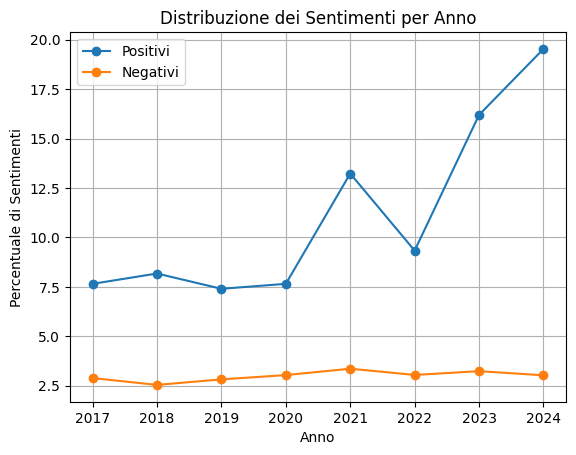

Anno: 2017, % Positivi: 7.65%, % Negativi: 2.89%
Anno: 2018, % Positivi: 8.18%, % Negativi: 2.54%
Anno: 2019, % Positivi: 7.40%, % Negativi: 2.82%
Anno: 2020, % Positivi: 7.65%, % Negativi: 3.04%
Anno: 2021, % Positivi: 13.23%, % Negativi: 3.36%
Anno: 2022, % Positivi: 9.33%, % Negativi: 3.05%
Anno: 2023, % Positivi: 16.19%, % Negativi: 3.24%
Anno: 2024, % Positivi: 19.53%, % Negativi: 3.03%


In [21]:
import json
from collections import defaultdict
from datetime import datetime
import matplotlib.pyplot as plt
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.nn.functional import softmax
import networkx as nx

# Carica il modello pre-addestrato e il tokenizer
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Funzione per analizzare il sentimento come positivo o negativo
def analyze_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    probs = softmax(outputs.logits, dim=1)
    sentiment_score = torch.argmax(probs).item()  # Ritorna 0 (negativo), 1 (neutro), o 2 (positivo)

    # Considera solo sentimenti positivi o negativi (ignora i neutri)
    if sentiment_score == 0:
        return 'negativo'
    elif sentiment_score == 2:
        return 'positivo'
    else:
        return 'neutro'

# Funzione per estrarre i commenti dai nodi della rete e raggrupparli per anno
def group_comments_by_year_from_graph(graph):
    comments_by_year = defaultdict(list)
    for node, data in graph.nodes(data=True):
        comments_serialized = data.get('comments', '[]')
        try:
            comments_data = json.loads(comments_serialized)
            for comment_list in comments_data:
                if isinstance(comment_list, list):
                    for comment in comment_list:
                        if isinstance(comment, dict) and 'text' in comment and 'published_at' in comment:
                            comment_text = comment['text']
                            published_at = comment['published_at']
                            year = datetime.strptime(published_at, "%Y-%m-%dT%H:%M:%SZ").year
                            comments_by_year[year].append(comment_text)
                        else:
                            print(f"Struttura inattesa per commento: {comment}")
                else:
                    print(f"Struttura inattesa per comment_list: {comment_list}")
        except json.JSONDecodeError as e:
            print(f"Errore nel parsing dei commenti per il nodo {node}: {e}")
    return comments_by_year

# Funzione per calcolare la distribuzione dei sentimenti per anno
def calculate_sentiment_distribution_by_year(comments_by_year):
    sentiment_distribution_by_year = {}
    for year, comments in comments_by_year.items():
        sentiment_counts = {'positivo': 0, 'negativo': 0}
        for comment in comments:
            sentiment = analyze_sentiment(comment)
            if sentiment in sentiment_counts:
                sentiment_counts[sentiment] += 1
        
        total_comments = len(comments)
        if total_comments > 0:
            positive_percentage = (sentiment_counts['positivo'] / total_comments) * 100
            negative_percentage = (sentiment_counts['negativo'] / total_comments) * 100
        else:
            positive_percentage = 0
            negative_percentage = 0
        
        sentiment_distribution_by_year[year] = {'positivo': positive_percentage, 'negativo': negative_percentage}
    
    return sentiment_distribution_by_year

# Carica la rete dal file .gexf
G = nx.read_gexf('rete_con_data.gexf')

# Raggruppa i commenti per anno
comments_by_year = group_comments_by_year_from_graph(G)

# Calcola la distribuzione dei sentimenti per anno
sentiment_distribution_by_year = calculate_sentiment_distribution_by_year(comments_by_year)

# Visualizza la distribuzione dei sentimenti per anno
years = sorted(sentiment_distribution_by_year.keys())
positive_percentages = [sentiment_distribution_by_year[year]['positivo'] for year in years]
negative_percentages = [sentiment_distribution_by_year[year]['negativo'] for year in years]

plt.plot(years, positive_percentages, marker='o', label='Positivi')
plt.plot(years, negative_percentages, marker='o', label='Negativi')
plt.title('Distribuzione dei Sentimenti per Anno')
plt.xlabel('Anno')
plt.ylabel('Percentuale di Sentimenti')
plt.legend()
plt.grid(True)
plt.show()

# Stampa i risultati
for year in years:
    print(f"Anno: {year}, % Positivi: {positive_percentages[years.index(year)]:.2f}%, % Negativi: {negative_percentages[years.index(year)]:.2f}%")


In [1]:
import networkx as nx
import json

# Carica la rete dal file .gexf
G = nx.read_gexf('rete_con_data.gexf')

# Funzione per contare il numero totale di commenti per ciascun commentatore
def count_total_comments(graph):
    total_comments = {}
    for node in graph.nodes:
        # Ottieni l'attributo 'comments' del nodo
        comments_serialized = graph.nodes[node].get('comments', '[]')  # Prendi i commenti o una lista vuota se l'attributo non esiste
        try:
            # Decodifica i commenti da JSON
            comments_data = json.loads(comments_serialized)
            # Conta il numero totale di commenti associati a questo nodo
            total_comments[node] = sum(len(comment_list) for comment_list in comments_data if isinstance(comment_list, list))
        except json.JSONDecodeError as e:
            print(f"Errore nel parsing dei commenti per il nodo {node}: {e}")
            total_comments[node] = 0  # Se c'è un errore, assegna 0 commenti
    return total_comments

# Conta i commenti totali per ciascun nodo
total_comments_per_node = count_total_comments(G)

# Assegna l'attributo 'total_comments' ad ogni nodo nella rete
nx.set_node_attributes(G, total_comments_per_node, 'total_comments')

# Calcola l'assortatività in base all'attività dei commentatori (numero totale di commenti)
assortativity_activity = nx.numeric_assortativity_coefficient(G, 'total_comments')
print(f"Assortatività basata sull'attività dei commentatori: {assortativity_activity:.4f}")


Assortatività basata sull'attività dei commentatori: -0.1300



Sovrapposizione di pubblico per la Comunità 2:
  - Dal 2017 al 2018: Sovrapposizione del 8.96%
  - Dal 2017 al 2019: Sovrapposizione del 2.00%
  - Dal 2017 al 2020: Sovrapposizione del 1.67%
  - Dal 2017 al 2021: Sovrapposizione del 3.12%
  - Dal 2017 al 2022: Sovrapposizione del 0.00%
  - Dal 2017 al 2023: Sovrapposizione del 0.00%
  - Dal 2017 al 2024: Sovrapposizione del 0.00%
  - Dal 2018 al 2019: Sovrapposizione del 11.29%
  - Dal 2018 al 2020: Sovrapposizione del 7.03%
  - Dal 2018 al 2021: Sovrapposizione del 5.80%
  - Dal 2018 al 2022: Sovrapposizione del 3.64%
  - Dal 2018 al 2023: Sovrapposizione del 4.82%
  - Dal 2018 al 2024: Sovrapposizione del 2.38%
  - Dal 2019 al 2020: Sovrapposizione del 38.38%
  - Dal 2019 al 2021: Sovrapposizione del 8.59%
  - Dal 2019 al 2022: Sovrapposizione del 5.29%
  - Dal 2019 al 2023: Sovrapposizione del 1.92%
  - Dal 2019 al 2024: Sovrapposizione del 2.49%
  - Dal 2020 al 2021: Sovrapposizione del 9.12%
  - Dal 2020 al 2022: Sovrapposizione 

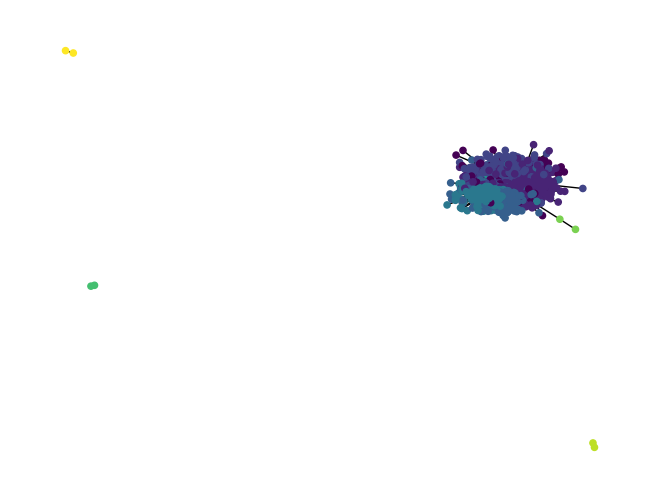

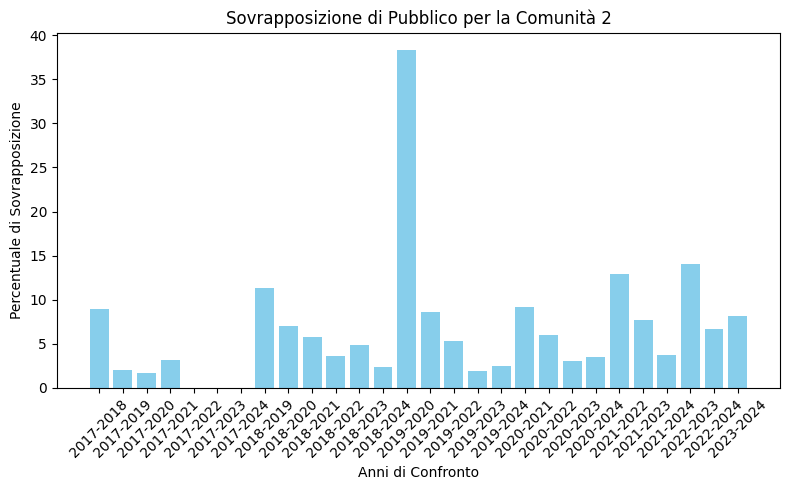

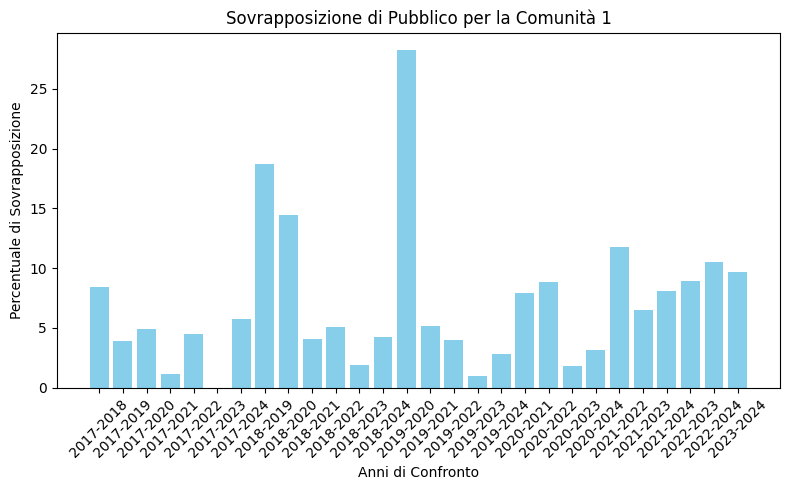

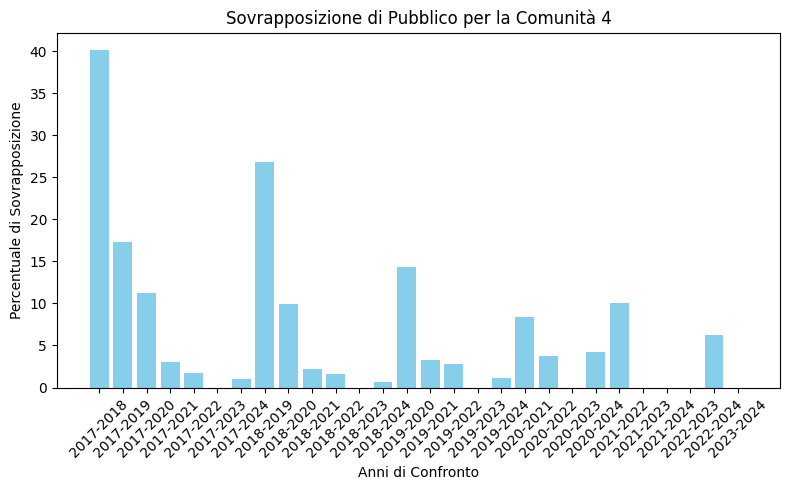

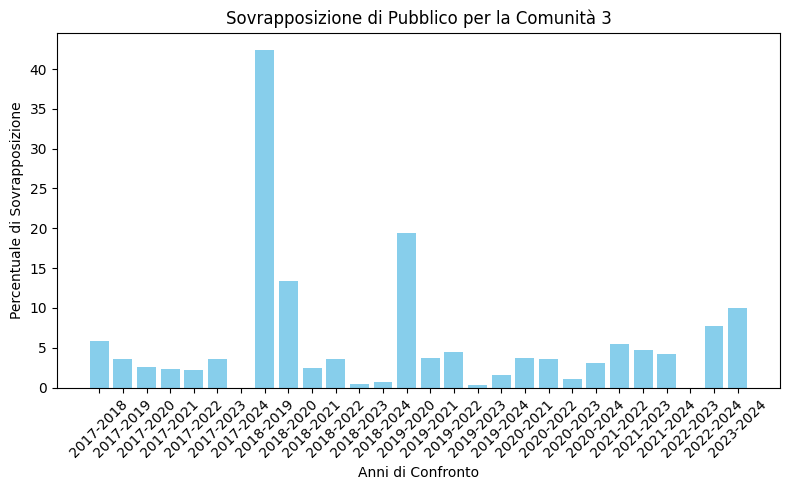

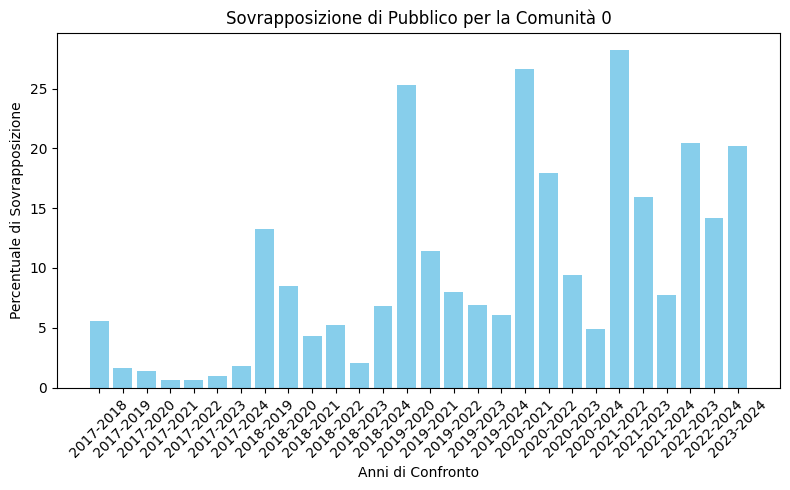

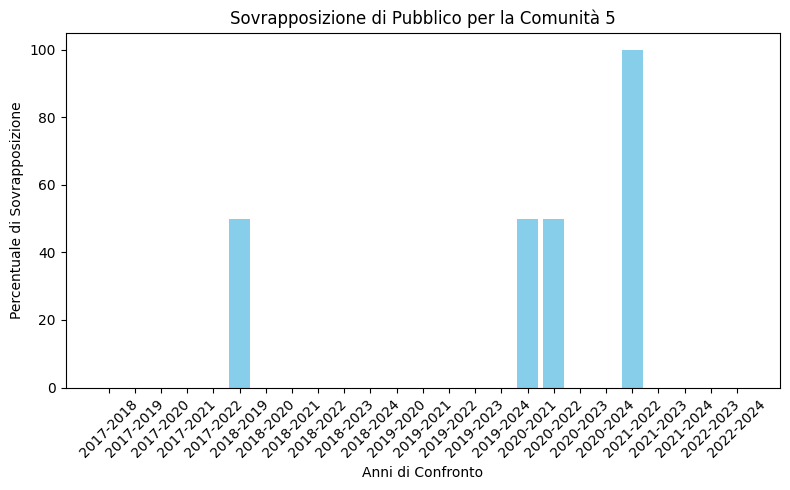

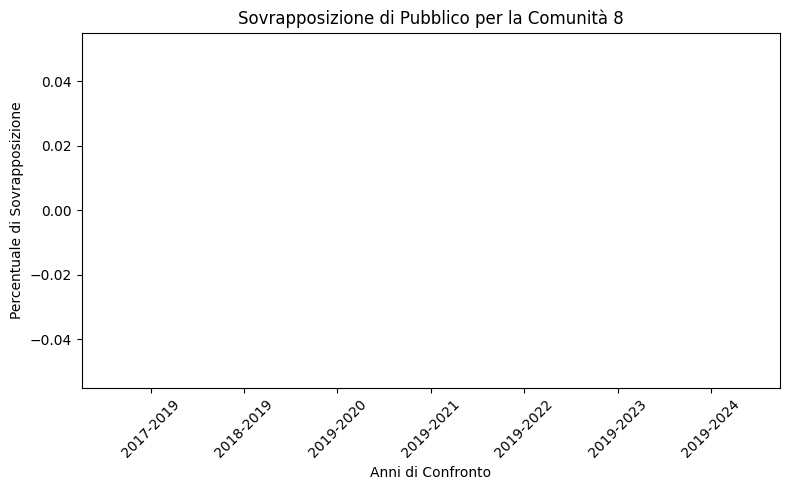

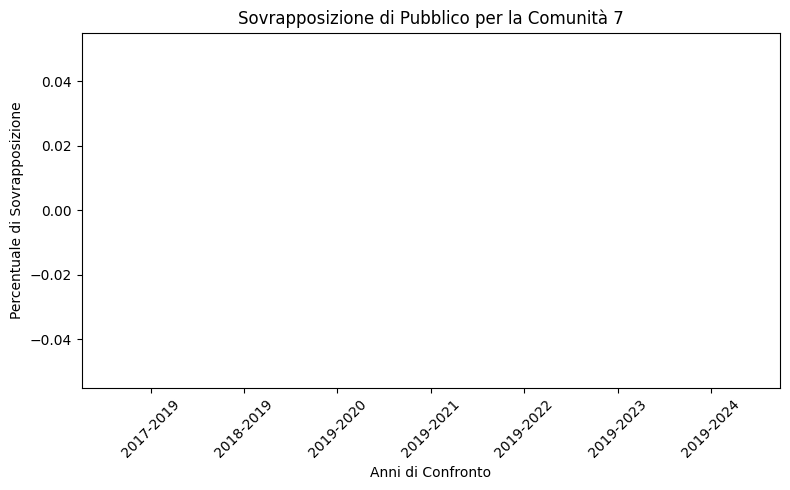

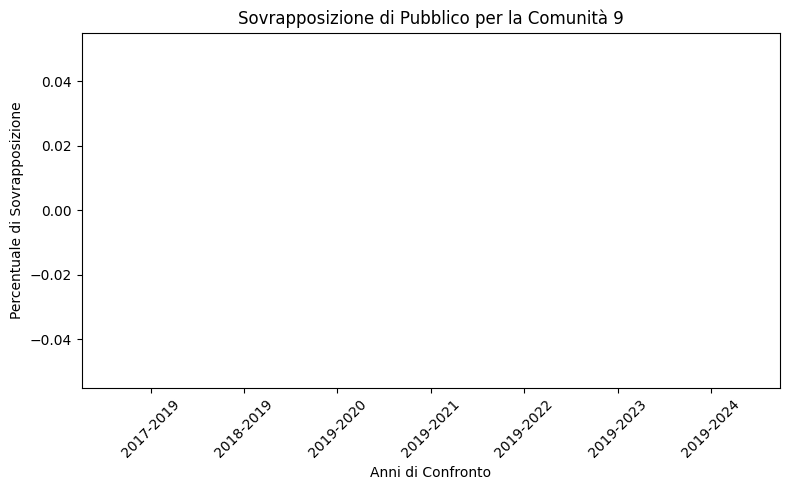

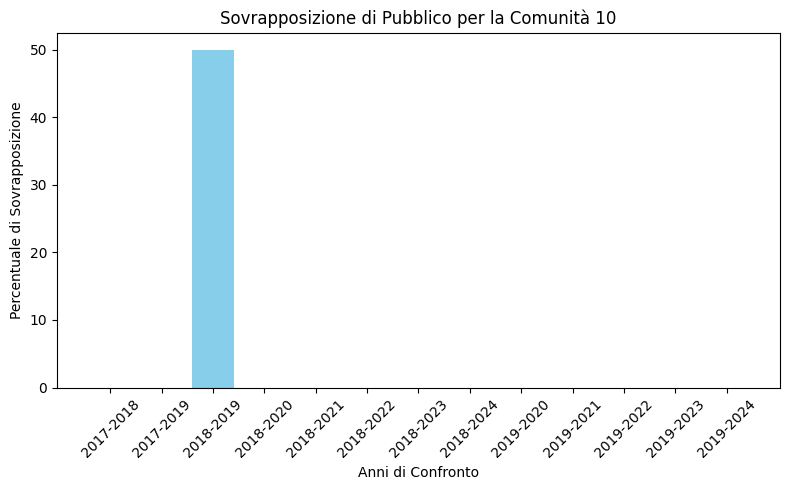

In [3]:
import networkx as nx
from collections import defaultdict
import json
from itertools import combinations
import matplotlib.pyplot as plt
from community import community_louvain

# Carica la rete dal file .gexf
G = nx.read_gexf('rete_con_data.gexf')

# Rilevamento delle comunità usando l'algoritmo di Louvain
partition = community_louvain.best_partition(G)

# Ordina le comunità per dimensione e seleziona le 10 più grandi
community_sizes = defaultdict(int)
for community_id in partition.values():
    community_sizes[community_id] += 1
sorted_communities = sorted(community_sizes.items(), key=lambda x: x[1], reverse=True)
top_communities = [community_id for community_id, _ in sorted_communities[:10]]

# Inizializza dizionari per i nodi delle comunità per ogni anno dal 2017 al 2024
nodes_by_year = {year: defaultdict(set) for year in range(2017, 2025)}

# Popola i dizionari con i nodi per ogni anno
for node, community_id in partition.items():
    if community_id in top_communities and 'comments' in G.nodes[node]:
        comments = json.loads(G.nodes[node]['comments'])
        if isinstance(comments, list):
            for comment_list in comments:
                if isinstance(comment_list, list):
                    for comment in comment_list:
                        if isinstance(comment, dict) and 'published_at' in comment:
                            year = comment['published_at'].split('-')[0]
                            if year.isdigit() and int(year) in range(2017, 2025):
                                nodes_by_year[int(year)][community_id].add(node)

# Calcola e stampa la sovrapposizione in percentuale per ciascuna coppia di anni
overlap_data = defaultdict(list)

for community_id in top_communities:
    print(f"\nSovrapposizione di pubblico per la Comunità {community_id}:")
    for year1, year2 in combinations(range(2017, 2025), 2):
        nodes_in_year1 = nodes_by_year[year1][community_id]
        nodes_in_year2 = nodes_by_year[year2][community_id]
        total = len(nodes_in_year1 | nodes_in_year2)
        if total > 0:
            overlap = len(nodes_in_year1 & nodes_in_year2)
            percentage_overlap = (overlap / total) * 100
            print(f"  - Dal {year1} al {year2}: Sovrapposizione del {percentage_overlap:.2f}%")
            overlap_data[community_id].append((f"{year1}-{year2}", percentage_overlap))

# Visualizzazione della Rete Focalizzata sulle 10 Comunità
subgraph_nodes = [node for node, community_id in partition.items() if community_id in top_communities]
subgraph = G.subgraph(subgraph_nodes)

pos = nx.spring_layout(subgraph)
nx.draw(subgraph, pos, with_labels=False, node_size=20, node_color=[partition[n] for n in subgraph_nodes])
plt.show()

# Rappresentazione grafica delle percentuali di sovrapposizione
for community_id in top_communities:
    if overlap_data[community_id]:
        labels, values = zip(*overlap_data[community_id])
        plt.figure(figsize=(8, 5))
        plt.bar(labels, values, color='skyblue')
        plt.xticks(rotation=45)
        plt.xlabel('Anni di Confronto')
        plt.ylabel('Percentuale di Sovrapposizione')
        plt.title(f'Sovrapposizione di Pubblico per la Comunità {community_id}')
        plt.tight_layout()
        plt.show()
